[0.3, 0.5, 0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.4]
[0.3, 0.7, 0.9, 1.2, 1.4, 1.6, 1.7, 1.8, 1.9]
[0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.6]
[0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.0]


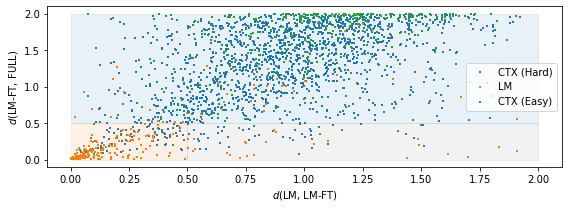

In [8]:
from typing import List
from statistics import quantiles
import pandas as pd
import csv
import os
import statistics
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
colors = mcolors.TABLEAU_COLORS

keys_matter = ['pos', 'lm_imp', 'lm2imp', 'imp_cnn_imp', 'imp_cnn2imp', 'imp_full', 'imp2full', 'token',
               'pert_var', 'pert_distb', 'pert_sents', 'top_lm', 'top_imp', 'top_full', 'top_impood', 'top_attn']


def show_quantiles(var):
    print([round(q, 1) for q in quantiles(var, n=10)])


def load_csv(fname_w_dir):
    data = []
    with open(fname_w_dir, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',',)
        for row in spamreader:
            data.append(row)
    return data


def comp_var(inp_list):
    if not inp_list:
        return 0
    max_value = max(inp_list)
    v = statistics.mean([abs(this_v - max_value) for this_v in inp_list])
    return v


def create_dict_of_keys(pack, all_keys):
    retrieved = {}
    for k in keys_matter:
        if k in all_keys:
            index = all_keys.index(k)
            v = pack[index]

            try:
                v = eval(v)
                v = float(v)
            except:
                pass
            retrieved[k] = v
    return retrieved


def rt_values(query_dict, keys: List):
    out = []
    for k in keys:
        if k in query_dict:
            out.append(query_dict[k])
    return out


def process_one_pack(data_pack, keys):
    ret_pairs = create_dict_of_keys(data_pack, keys)
    # if random.random() < 0.01:
        # print(ret_pairs)
    flag = True
    distance_x_inp = rt_values(
        ret_pairs, ['lm_imp', 'lm2imp', 'imp_cnn_imp', 'imp_cnn2imp'])
    distance_x = min(distance_x_inp)

    if ret_pairs['top_impood'][0][1] == '<s>':
        flag = False
    #     print(pnum(distance_x))
    #     print(ret_pairs['token'])
    #     print(ret_pairs['top_lm'])
    #     print(ret_pairs['top_imp'])
    #     print(ret_pairs['top_impood'])
    distance_y = min(rt_values(ret_pairs, ['imp_full', 'imp2full']))

    pert_distribution = ret_pairs['pert_distb']
    pert_distribution = [float(m) for m in pert_distribution]
    variation = comp_var(pert_distribution)
    max_pert = max(pert_distribution)
    return distance_x, distance_y, variation, max_pert,flag


def draw_map_figure(x, y, pert_v, pert_max):
    labels = []
    CNT_EZ = "CTX (Easy)"
    CNT_HD = "CTX (Hard)"
    LM = "LM"
    for a, b, c, d in zip(x, y, pert_v, pert_max):
        # if c < 0.2 and d < 0.3:
            # l = 'var & max'
        # elif c > 0.3 and d < 0.3:
        #     l = 'VAR & max'
        if c > 0.3 and d > 0.8:
            l = CNT_EZ
        elif c < 0.1 and d > 0.8:
            l = LM
        else:
            l = CNT_HD

        labels.append(l)

    fig, ax = plt.subplots(figsize=(8, 3))
    # f = plt.figure(figsize=(3, 3))
    # kw = dict(num=5, color=scatter.cmap(0.7), fmt="$ {x:.2f}", func=lambda s: np.sqrt(s/.3)/3)
    # legend2 = ax.legend(*scatter.legend_elements(**kw),loc="lower right", title="Price")
    s = 2
    oa = [a for a,b,c in zip(x,y,labels) if c == CNT_HD]
    ob = [b for a,b,c in zip(x,y,labels) if c == CNT_HD]
    scatter = ax.scatter(oa, ob, marker='+',s=s, label=CNT_HD)
    vMa = [a for a,b,c in zip(x,y,labels) if c == LM]
    vMb = [b for a,b,c in zip(x,y,labels) if c == LM]
    scatter = ax.scatter(vMa, vMb, marker='+',s=s, label=LM)
    VMa = [a for a,b,c in zip(x,y,labels) if c == CNT_EZ]
    VMb = [b for a,b,c in zip(x,y,labels) if c == CNT_EZ]
    scatter = ax.scatter(VMa, VMb, marker='+',s=s, label=CNT_EZ)
    ax.fill_between([0,2], [0.5, 0.5],[2,2] , color='C0', alpha=0.1)
    ax.fill_between([0,0.5], [0., 0.0],[0.5,0.5] , color='C1', alpha=0.1)
    ax.fill_between([0.5,2], [0., 0.0],[0.5,0.5] , color='grey', alpha=0.1)
    ax.legend()

    # scatter = ax.scatter(x, y, s=4)
    ax.set_xlabel(r'$d$(LM, LM-FT)')
    ax.set_ylabel(r'$d$(LM-FT, FULL)')
    # sns.scatterplot(x=x, y=y, hue=labels,s=4)
    # sns.jointplot(x=x, y=y, hue=labels, kind="kde")
    fig.tight_layout()
    fig.show()
    fig.savefig('map.pdf', format='pdf')


if __name__ == "__main__":
    debug = False
    fname = '/mnt/data0/jcxu/output_file.csv'
    # fname = '/mnt/data0/jcxu/output_file_test.csv'
    read_out = load_csv(fname)
    key = read_out[0]
    data = read_out[1:]
    if debug:
        data = data[:100]
    X, Y, Var, Max = [], [], [], []
    for d in data:
        distance_x, distance_y, variation, max_pert, flag = process_one_pack(d, key)
        if not flag:
            continue
        X.append(distance_x)
        Y.append(distance_y)
        Max.append(max_pert)
        Var.append(variation)
    show_quantiles(X)
    show_quantiles(Y)
    show_quantiles(Var)
    show_quantiles(Max)
    draw_map_figure(X, Y, Var, Max)
